# Time Series Forecasting for Circular Data, LSTMs in NumPy, and Multi-armed Bandits
## Matt Gorbett

This project took several different paths from my project proposal. I tried to cover the various experiments from my proposal, but some proved to be a waste of time.  One part of my project proposal was to train and predict data on all 4 wind turbines rather than a single turbine.  Quick training on all 4 wind turbines proved to have bad results.  Instead, I tried different training methods such as ensembling with weights based on validation datasets, different weight initializations, and alternative validation testing approaches.  <br>
Additionally, part of my project proposal was to understand the inner workings of an LSTM network.  I did this by building out an LSTM using only NumPy. 
Finally, the last part of my project completely diverged from my proposal.  I was listening to a podcast-This Week in Machine Learning & AI (TWiML), where a graduate student was talking about his recent paper regarding thompson sampling in deep queue networks.  This gave me the desire to implement thomspon sampling in a simple reinforcement learning problem.  I decided to implement the multi armed bandit algorithm from scratch, using a few different methods for bernoulli sampling including thompson sampling and UCB.  

# Contents
Part 1:
1.  [Overview of previous work](#overview)
2.  [Stationarity Analysis](#stationarity)
3.  [Persistance Model](#persistance)
4.  [Comparing Keras Models](#comparisons)
5.  [Manual Ensembling: weighted with validation set MAE/RMSE](#ensembling)
6.  [Better Validation Testing](#validation)
7.  [Weight Initialization Testing](#weights)
8.  [Conclusions and Future Considerations](#conclusions)

Part 2: <br>
1.  [An LSTM written in NumPy](#numpylstm)
2.  [LSTM Code Walkthrough](#numpylstm_walkthrough)

Part 3:
1.  [Solving the multiarmed bandit problem with random, greedy, epsilon, epsilon greedy, thompson sampling, UCB policies](#rl)


[References](#references)<br>
[Word Count](#wordcount)


<a id='overview'></a>
# Wind Direction Forecasting-Overview

Before this course I did some work predicting wind direction in a wind turbine dataset using time series forecasting.  Predicting time series can be done using LSTM, CNN, SVR, and numbers of statistical methods such as arima.  For this project I will concentrate on using LSTM networks for time series forecasting.

Wind direction is a circular variable, meaning it can be from 0-360 degrees.  Predicting the direction can be done by converting the wind direction value to sine(value/360x2pi) and cosine (value/360x2pi).  These values are between -1 and 1.  I convert them back using arcsin and arccos.  

Previous work from my github page with more info on my data setup:
-  https://mattgorb.github.io/wind_multivariatelstm
-  https://mattgorb.github.io/wind

The second link has my method for converting the wind direction to sine and cosine waves and converting them back to a circular prediction.  

Dataset: https://opendata-renewables.engie.com/explore/dataset/la-haute-borne-data-2013-2016/table/<br>
Variables: wa_c_avg (wind direction), Ws (wind speed), Ot (temperature)<br>




<a id='stationarity'></a>
## Stationarity Analysis

First I want to determine if my data is stationary or non stationary, and whether seasonality effects the outcome.  To do this I will print out the wind direction mean and variance for each year and then each season.  

A stationary time series is one whose statistical properties such as the mean, variance and autocorrelation are all constant over time. Hence, a non-stationary series is one whose statistical properties change over time. (https://www.quora.com/What-is-Stationary-series-and-non-Stationary-series)

For this exercise I will use a single turbine from the dataset. 

In [1]:
import numpy as np
import pandas as pd
import datetime

def firstTurbineData():
	df = pd.read_csv('la-haute-borne-data-2013-2016.csv', sep=';')
	df['Date_time'] = df['Date_time'].astype(str).str[:-6] #remove timezone (caused me an hour of pain)
	df.Date_time=pd.to_datetime(df['Date_time'])
	df=df.fillna(method='ffill')

	df=df.sort_values(by='Date_time')
	df = df.reset_index()
	turbines=df.Wind_turbine_name.unique()
	print("Turbine name: "+str(turbines[0]))
	turbineData=df[df['Wind_turbine_name']==turbines[0]]
	return turbineData


turbineData=firstTurbineData()

years=turbineData.Date_time.dt.year.unique().tolist()#unique years in dataset
years.pop(0) #remove 2012 from list since we only have the tail end of 2012 data.  

#Print Yearly mean/variance for wind direction
for y in years:
    data=turbineData[turbineData['Date_time'].dt.year==y].Wa_c_avg.values
    print("Year: "+str(y)+ " mean: " + str(np.mean(data))+" variance: "+str(np.var(data)))


def seasonal_statistics(data, name):
    print(str(name)+" mean: " + str(np.mean(data))+" variance: "+str(np.var(data)))
    
#Seasonality is defined as 12/21-3/21, 3/22-6/21...
print("\nSeasonality")
seasonal_statistics(turbineData[(turbineData['Date_time']>datetime.datetime(2012, 12, 21)) & (turbineData['Date_time']<datetime.datetime(2013, 3, 21) )].Wa_c_avg.values, "Winter 2013")
seasonal_statistics(turbineData[(turbineData['Date_time']>datetime.datetime(2013, 12, 21)) & (turbineData['Date_time']<datetime.datetime(2014, 3, 21) )].Wa_c_avg.values, "Winter 2014")
seasonal_statistics(turbineData[(turbineData['Date_time']>datetime.datetime(2014, 12, 21)) & (turbineData['Date_time']<datetime.datetime(2015, 3, 21) )].Wa_c_avg.values, "Winter 2015")
seasonal_statistics(turbineData[(turbineData['Date_time']>datetime.datetime(2015, 12, 21)) & (turbineData['Date_time']<datetime.datetime(2016, 3, 21) )].Wa_c_avg.values, "Winter 2016")

seasonal_statistics(turbineData[(turbineData['Date_time']>datetime.datetime(2013, 3, 21)) & (turbineData['Date_time']<datetime.datetime(2013, 6, 21) )].Wa_c_avg.values, "\nSpring 2013")
seasonal_statistics(turbineData[(turbineData['Date_time']>datetime.datetime(2014, 3, 21)) & (turbineData['Date_time']<datetime.datetime(2014, 6, 21) )].Wa_c_avg.values, "Spring 2014")
seasonal_statistics(turbineData[(turbineData['Date_time']>datetime.datetime(2015, 3, 21)) & (turbineData['Date_time']<datetime.datetime(2015, 6, 21) )].Wa_c_avg.values, "Spring 2015")
seasonal_statistics(turbineData[(turbineData['Date_time']>datetime.datetime(2016, 3, 21)) & (turbineData['Date_time']<datetime.datetime(2016, 6, 21) )].Wa_c_avg.values, "Spring 2016")

seasonal_statistics(turbineData[(turbineData['Date_time']>datetime.datetime(2013, 6, 21)) & (turbineData['Date_time']<datetime.datetime(2013, 9, 21) )].Wa_c_avg.values, "\nSummer 2013")
seasonal_statistics(turbineData[(turbineData['Date_time']>datetime.datetime(2014, 6, 21)) & (turbineData['Date_time']<datetime.datetime(2014, 9, 21) )].Wa_c_avg.values, "Summer 2014")
seasonal_statistics(turbineData[(turbineData['Date_time']>datetime.datetime(2015, 6, 21)) & (turbineData['Date_time']<datetime.datetime(2015, 9, 21) )].Wa_c_avg.values, "Summer 2015" )
seasonal_statistics(turbineData[(turbineData['Date_time']>datetime.datetime(2016, 6, 21)) & (turbineData['Date_time']<datetime.datetime(2016, 9, 21) )].Wa_c_avg.values, "Summer 2016")

seasonal_statistics(turbineData[(turbineData['Date_time']>datetime.datetime(2013, 9, 21)) & (turbineData['Date_time']<datetime.datetime(2013, 12, 21) )].Wa_c_avg.values, "\nFall 2013")
seasonal_statistics(turbineData[(turbineData['Date_time']>datetime.datetime(2014, 9, 21)) & (turbineData['Date_time']<datetime.datetime(2014, 12, 21) )].Wa_c_avg.values, "Fall 2014")
seasonal_statistics(turbineData[(turbineData['Date_time']>datetime.datetime(2015, 9, 21)) & (turbineData['Date_time']<datetime.datetime(2015, 12, 21) )].Wa_c_avg.values, "Fall 2015")
seasonal_statistics(turbineData[(turbineData['Date_time']>datetime.datetime(2016, 9, 21)) & (turbineData['Date_time']<datetime.datetime(2016, 12, 21) )].Wa_c_avg.values, "Fall 2016")


Turbine name: R80736
Year: 2013 mean: 171.2583191240095 variance: 10241.806036309075
Year: 2014 mean: 177.0322800418058 variance: 8191.131423097059
Year: 2015 mean: 180.32319156920616 variance: 9260.0192172841
Year: 2016 mean: 179.02708351059488 variance: 9120.598211332162

Seasonality
Winter 2013 mean: 169.06502443265148 variance: 10223.240640872438
Winter 2014 mean: 180.0378452078669 variance: 3957.4436134315383
Winter 2015 mean: 174.95637994976562 variance: 10118.279883664827
Winter 2016 mean: 174.94510128351519 variance: 7648.6769787195235

Spring 2013 mean: 171.466366625207 variance: 11312.092222900661
Spring 2014 mean: 175.299488347244 variance: 11380.52232791995
Spring 2015 mean: 182.3834821427918 variance: 10387.530680221793
Spring 2016 mean: 195.9735849251427 variance: 8725.832637505944

Summer 2013 mean: 173.70260205401698 variance: 11591.478712740089
Summer 2014 mean: 176.94886539224964 variance: 9932.212941357642
Summer 2015 mean: 191.19453071081915 variance: 9717.775438121

The mean and variance stay fairly consistent over time.  There are some exceptions of course, but overall, the data has some stationarity to it.  This indicates to me that the wind is usually coming from the same direction to the wind turbine.  I would consider this data at least semi-stationary.  

<a id='persistance'></a>
## Persistance Model



In the following code I calculate the Mean Absolute Error (MAE) and the Root Mean Squared Error (RMSE) for the days 1/1/16 to 1/7/16 using the persistance model.  The persistance model is a basic structure that takes the time series' previous value as the prediction.  For example if you are looking to predict a value at time t then you would predict its value to be t-1.  Value t+1 would be predicted as t, and so on.  

Dr. Anderson mentioned in my project proposal that I should compare any time series model with the persistance model.  I found [this link](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424), which indicates that "Baseline forecasts with the persistence model quickly indicate whether you can do significantly better. If you can’t, you’re probably dealing with a random walk (or close to it)."  A random walk is a stochastic process, as the name indicates.

Here is the persistance model rmse and mae for a single turbine on the first six days of the year: 

In [4]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math
turbineData=firstTurbineData()
results = pd.DataFrame(columns=['test_date','rmse','mae'])
for i in range(1,10):
    date_to_test=datetime.datetime(2016, 1, i)
    start_date=date_to_test-datetime.timedelta(minutes = 10)
    end_date=date_to_test+datetime.timedelta(days = 1)
    
    actual=[]
    predicted=[]

    turbine=turbineData[(turbineData['Date_time']>= start_date) & (turbineData['Date_time']<end_date)].Wa_c_avg.values

    actual.extend(turbine[1:])
    predicted.extend(turbine[:-1])

    mae=mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = math.sqrt(mse)

    predicted=pd.DataFrame(predicted)

    results = results.append({'test_date':str(date_to_test)[:10], 'rmse': rmse,'mae': mae}, ignore_index=True)
print(results)

Turbine name: R80736
    test_date      rmse       mae
0  2016-01-01  9.113613  6.214375
1  2016-01-02  4.974602  3.309235
2  2016-01-03  8.133943  5.054027
3  2016-01-04  5.673105  3.596944
4  2016-01-05  5.667746  4.092013
5  2016-01-06  9.591719  5.901806
6  2016-01-07  5.978294  3.792083
7  2016-01-08  9.549897  7.279861
8  2016-01-09  6.427645  4.233056


A look at the results from my Multi Variate LSTM training from a few months ago (located at https://mattgorb.github.io/wind_multivariatelstm): 

|Date  |RMSE|MAE|
|------|------|------|
|2016-01-01|11.2|7.29|
|2016-01-02|4.5|3.28|
|2016-01-03|5.99|4.29|
|2016-01-04|6.40|4.08|
|2016-01-05|5.40|3.82|
|2016-01-06|5.78|4.01|
|2016-01-07|7.69|5.10| 
|2016-01-08|11.69|8.2|
|2016-01-09|7.11|4.99|

#### Out of the 18 scores available here, the persistance model did better on 10/18 scores.  This indicates to me that the model is a random walk with an inability to learn from the data.  
I was able to stack the predictions from my multivariate LSTM and the persistance model and average the predictions together, which gave me slightly before results. 
#### From here on I will be doing experiments on a smaller dataset to compare different techniques.  I am not doing GPU training since its too expensive, both computationally and in my wallet!.  

<a id='comparisons'></a>
## Comparing Keras Models
Below are several models I trained and experimented with.  

These models were trained on the same data.  I trained each models to test on 3 different days, 1/1/16,1/2/16, and 1/3/16.  The validation set consisted of the previous day from the test set.  The training set consisted of the previous 75 days worth of data, with each row containing 6 days worth of data.  Since each day consists of 144 records, the datasets np.shape looks like the following: 

#### Training Set: 
(10656, 864, 3)<br>
75 days*144 records each day-144 records for validation set=10,656 rows.  <br>
6 days columns *144 each day-864 columns<br>
3 variables for each point (wind direction, wind speed, outdoor temperature)<br>

##### Test, Validation Sets
(144, 864, 3)<br>
144 records in a day<br>
6 days columns *144 each day-864 columns <br>
3 variables for each point (wind direction, wind speed, outdoor temperature)<br><br>


## Model notes
Constants: adam optimization, training/test size, Dropout Regularization=.2 after each layer.  

|Model|Type|Layers|Nodes|Loss Function|Shuffle|stateful/reset (Y/N)|
|------|------|------|------|------|------|------|
|1|LSTM|1|16|mae|False|N|
|2|LSTM|1|8||mae|False|N|
|3|LSTM|1|32|mae|False|N|
|4|LSTM|2|4,4|mae|False|N|
|5|LSTM|1|4|rmse|False|N|
|6|LSTM|1|8|mae|False|Y|
|7|LSTM|1|8|rmse|True|N|
|8|LSTM|1|4|rmse|True|N|
|9|LSTM|1|8|mae|False|Y|
|10|LSTM|1|8|rmse|False|Y|



Models 1-5 were normal, stateless LSTM's with differing nodes, layers, and loss functions.  MAE seemed to consistently do better during my training.  <br>

Models 7-8 were stateless LSTMs with shuffling set to True.  

Models 6, 9-10 are stateful LSTM's.  I seemed to have the most success with these according to the results below. 

### Stateful vs. Stateless LSTM
[This link](https://machinelearningmastery.com/stateful-stateless-lstm-time-series-forecasting-python/) was really helpful in understanding difference between stateful and stateless LSTMs, and how we should use each.  
#### Stateless
The state of the model is reset after each training batch.

#### Stateful
The state of the model is reset only when reset_state() is called in keras.  For my models, I am resetting after each epoch.  


In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dropout
from keras.layers import  CuDNNLSTM
from keras import optimizers

#adam optimizer with default rates.  
adam=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

#Model 1
model.add(LSTM(16, input_shape=(testX.shape[1], testX.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_absolute_error', optimizer=adam)

#model 2
model.add(LSTM(8, input_shape=(testX.shape[1], testX.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=adam)

#model 3
model.add(LSTM(4, input_shape=(testX.shape[1], testX.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_absolute_error', optimizer=adam)

#model 4
model.add(LSTM(4, input_shape=(testX.shape[1], testX.shape[2]),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(4))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=adam)

#model 5
model.add(LSTM(4, input_shape=(testX.shape[1], testX.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=adam)


#Model 6
model.add(LSTM(8, batch_input_shape=(testX.shape[0],testX.shape[1], testX.shape[2]), stateful=True))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')
for i in range(5):
    model.fit(trainX_initial, trainY_initial, validation_data=(validationX, validationY),epochs=30, batch_size=testX.shape[0], verbose=2, shuffle=False)
    model.reset_states()


#model 7-shuffle true
model.add(LSTM(8, input_shape=(testX.shape[1], testX.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=adam)
model.fit(trainX_initial, trainY_initial, validation_data=(validationX, validationY),epochs=30, batch_size=testX.shape[0], verbose=2, shuffle=True)


#model 8-shuffle true
model.add(LSTM(4, input_shape=(testX.shape[1], testX.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=adam)
                
#model 9
model.add(LSTM(8, batch_input_shape=(testX.shape[0],testX.shape[1], testX.shape[2]), stateful=True))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')
for i in range(5):
        model.fit(trainX_initial, trainY_initial, validation_data=(validationX, validationY),epochs=10, batch_size=testX.shape[0], verbose=2, shuffle=False)
        model.reset_states()


#model 10
#stateful
model.add(LSTM(8, batch_input_shape=(testX.shape[0],testX.shape[1], testX.shape[2]), stateful=True))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

for i in range(5):
        model.fit(trainX_initial, trainY_initial, validation_data=(validationX, validationY),epochs=10, batch_size=testX.shape[0], verbose=2, shuffle=False)
        model.reset_states()

            


## Training and Callbacks

I added the following callbacks to the training on each of the stateless models:<br>
ReduceLROnPlateau: If the validation set loss doesn't decrease in 2 epochs I will halve the learning rate.  <br>
EarlyStopping:  If the validation loss doesn't improve in 5 epochs, I will end the training.  Minimum change is 0. <br>
ModelCheckpoint: Only save weights for the model when the validation loss has improved.  
<br><br>
Training:  I feed the training method training and validation data with a batch size=144, no shuffling, and the list of callbacks above.  
Code below. 

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.000001, verbose=1)
checkpointer=ModelCheckpoint('weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
earlystopper=EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
model.fit(trainX_initial, trainY_initial, validation_data=(validationX, validationY),epochs=30, batch_size=testX.shape[0], verbose=2, shuffle=False,callbacks=[checkpointer, earlystopper, reduce_lr])        

## Results


|Date|Model 1|mae|rmse|Model 2|mae|rmse|Model 3|mae|rmse|Model 4|mae|rmse|
|------|------|------|------|------|------|------|------|------|------|------|------|------|
|2016-01-01|-|11.132833|15.008581|-|12.995749|18.013858|-|15.819534|20.218835|-|18.058130|23.207323|
|2016-01-02|-|4.215699|5.686442|-|5.644555|7.325435|-|4.208258|5.581017|-|5.471353 |7.309605|
|2016-01-03|-|6.929635|9.113529|-|9.854110| 11.997647|-|8.457990|10.596992|-|10.320796|13.243282|


|Date|Model 5:|mae|rmse|Model 6:|mae|rmse|Model 7:|mae|rmse|
|------|------|------|------|------|------|------|------|------|------|
|2016-01-01|-|17.856244|22.631304|-|9.883107|13.322008|-|10.735319|15.443263|
|2016-01-02|-|5.151393|6.878382|-|3.343367|4.565645|-|4.928734|6.508967|
|2016-01-03|-|9.248170|11.711768|-|5.457156|7.486818|-|6.826818|9.645841|


|Date|Model 8|degrees_mae|rmse|Model 9|degrees_mae|rmse|Model 10|degrees_mae|rmse|
|------|------|------|------|------|------|------|------|------|------|
|2016-01-01|-|11.104123|16.318785|-|11.031389|14.650800|-|12.237451|16.953266|
|2016-01-02|-|4.702615|6.148375|-|3.519534|4.774981|-|5.372925|7.099109|
|2016-01-03|-|8.826431|11.568850|-|5.257079|7.249314|-|9.937034|12.236369|

Best Models: 6, 9, 3, 1


<a id='ensembling'></a>
# Ensembling

I attempted to ensemble 4 models to an Average() layer in Keras, however [I ran into issues](https://github.com/keras-team/keras/issues/9385).  <br>

There is currently a bug when stacking stateful submodels in a keras ensemble.  I instead stacked 4 stateless models manually.  

Stacking method:
1.  Train 4 models on sine data and 4 models on cosine data
2.  Retrieve the validation set rmse and mae for each model.  
3.  Ensemble 4 sine model predictions together by weighting them using RMSE or MAE:
    - The lower the error on a validation set for a model, the more weight its predictions receive.  
    -  Code for this is in the method 'weightedPredictions' below.  
4.  Do the same for 4 cosine models.
5.  Ensemble sine and cosine ensembles together using the same method I have been using all along. 

My results didn't improve predictions.  
Ideas for enhancement:
-  More variance in models
-  Ensemble with persistance model


#### Results
#### Model 1
MAE weighted: 9.296 rmse: 14.09<br>
RMSE weighted mae: 9.409301262546116 rmse: 14.128<br>
#### Model 2
MAE weighted: 9.64 rmse: 14.314<br>
RMSE weighted mae: 9.77 rmse: 14.39<br>
#### Model 3
MAE weighted: 9.34 rmse: 14.06<br>
RMSE weighted mae:9.51 rmse: 14.14<br>
#### Model 4
MAE weighted: 8.63 rmse: 13.53<br>
RMSE weighted mae:8.66 rmse: 13.5<br>
#### Ensembled
MAE weighted: 9.30 rmse: 14.01<br>
RMSE weighted mae:9.32 rmse: 14.02<br>

A little bit of the code below:

In [ ]:
def errors(actual,predicted):
        mae=mean_absolute_error(actual, predicted)
        rmse = sqrt(mean_squared_error(actual, predicted))
        return mae, rmse

def weightedPredictions(predictions,errors):
        inverseErrorTotal=0
        for e in errors:
                inverseErrorTotal+=(sum(errors)-e)
        weighted= np.zeros(predictions[0].shape)
        for p,e in zip(predictions,errors):
                prediction_weight=(sum(errors)-e)/inverseErrorTotal
                weighted+=(p*prediction_weight)
        return weighted

results = pd.DataFrame(columns=['test_date','degrees_mae','rmse'])


date_to_test=datetime.datetime(2016, 1, 1)
currentTurbine,total,recordsBack, trainSet=dataSetup(date_to_test)

trainX_initial, trainY_initial, validationX, validationY, testX,testY,actual=setupTrainTestSets(currentTurbine,total,recordsBack, trainSet)
testPredict_sin_1,validation_sin1=train_predict(1,False)
testPredict_sin_2,validation_sin2=train_predict(2,False)
testPredict_sin_3,validation_sin3=train_predict(3,False)
testPredict_sin_4,validation_sin4=train_predict(4,False)

val_mae_sin_1,val_rmse_sin_1=errors(validationY,validation_sin1)
val_mae_sin_2,val_rmse_sin_2=errors(validationY,validation_sin2)
val_mae_sin_3,val_rmse_sin_3=errors(validationY,validation_sin3)
val_mae_sin_4,val_rmse_sin_4=errors(validationY,validation_sin4)

val_ensemble_sin_mae=weightedPredictions([validation_sin1,validation_sin2,validation_sin3,validation_sin4],[val_mae_sin_1,val_mae_sin_2,val_mae_sin_3,val_mae_sin_4])
val_ensemble_sin_rmse=weightedPredictions([validation_sin1,validation_sin2,validation_sin3,validation_sin4],[val_rmse_sin_1,val_rmse_sin_2,val_rmse_sin_3,val_rmse_sin_4])


<a id='validation'></a>

# Better Validation Testing
![Backtesting](https://cdn-images-1.medium.com/max/2000/1*ETxu0I0BXP1M45pRRfph_Q.png)
Link from: https://medium.com/cindicator/backtesting-time-series-models-weekend-of-a-data-scientist-92079cc2c540

Up until now, I've been doing validation on a single day of data.  On top of this, I've been saving the models weights based on loss of this single dataset of 144 values.  In this exercise I built iterative time stepping of the training and test sets.  Code below

In [ ]:
def train_predict():
        model = Sequential()
        model.add(LSTM(8, input_shape=(trainX.shape[1],trainX.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mean_absolute_error', optimizer='adam')

        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=2, min_lr=0.000001, verbose=1)                                  
        earlystopper=EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

        validatons=3
        for i in reversed(range (1,validatons)):
            if(cos):
                weightFile='weights'+str(i)+'_cos.h5'                
            else:
                weightFile='weights'+str(i)+'_sin.h5'
            checkpointer=ModelCheckpoint(weightFile, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
            model.fit(trainX[:-144*i], trainY[:-144*i], validation_data=(trainX[-144*i:len(trainX)-144*(i-1)], trainY[-144*i:len(trainX)-144*(i-1)]),epochs=25, batch_size=testX.shape[0], verbose=2, shuffle=False,callbacks=[checkpointer,earlystopper])

        testPredict=[]
        validationPredict=[]
        for i in reversed(range (1,validatons)):
                if(cos):
                        weightFile='weights'+str(i)+'_cos.h5'                
                else:
                        weightFile='weights'+str(i)+'_sin.h5'               

                model.load_weights(weightFile)
                validationPredict.append(model.predict(validationX,batch_size=testX.shape[0]))
                testPredict.append(model.predict(testX, batch_size=testX.shape[0]))                   
                
        average_test=sum(testPredict) / float(len(testPredict))
        average_val=sum(validationPredict) / float(len(validationPredict))
        return average_test, average_val


Results here were inconclusive, but overall the method seems to be a bit better than validating on a single validation set. 

<a id='weights'></a>
# Weight Initialization

I learned from previous projects that weight initialization matters quite a bit.  This is why many Kaggle competitions are won using pre-trained networks.  In Keras, we can load weights from successful pre-trained models, however I have never done this with an LSTM. 

Default weight initializations for Keras are:<br>
kernel_initializer='glorot_uniform'<br>
recurrent_initializer='orthogonal'<br>

Initializations as defined on [Keras website](https://keras.io/layers/recurrent/)
#### kernel_initializer: 
Initializer for the kernel weights matrix, used for the linear transformation of the inputs. <br>
#### recurrent_initializer: 
Initializer for the recurrent_kernel weights matrix, used for the linear transformation of the recurrent state. <br> <br>
I tried the following weight initializations:

In [ ]:
if(model_num==1):
        model.add(LSTM(16, batch_input_shape=(testX.shape[0],testX.shape[1], testX.shape[2]),kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal'))
if(model_num==2):
        model.add(LSTM(16, batch_input_shape=(testX.shape[0],testX.shape[1], testX.shape[2]),kernel_initializer='glorot_normal', recurrent_initializer='orthogonal'))
if(model_num==3):
        model.add(LSTM(16, batch_input_shape=(testX.shape[0],testX.shape[1], testX.shape[2]),kernel_initializer='glorot_uniform', recurrent_initializer='glorot_normal'))
if(model_num==4):
        model.add(LSTM(16, batch_input_shape=(testX.shape[0],testX.shape[1], testX.shape[2]),kernel_initializer='he_normal', recurrent_initializer='orthogonal'))

        

#### Results
|Model|mae|rmse|
|------|------|------|
|1 |9.05|12.84|
|2|10.03|14.58|
|3|9.61|14.10|
|4|9.21|13.06|


#### Conclusions
I need to do more experimentation with different combinations of the different initializers.  Additionally, I only trained these for 50 epochs.  I would want to train them for 100 epochs to see if they are able to train and converge better with these different initialized weights.  

<a id='conclusions'></a>
# Conclusions and Future Considerations

Hard lessons were learned in this exercise.  During my previous project I threw expensive GPU at this problem.  However I found that the persistance model performed better than the LSTM models.   I do believe the above techniques can be combined together for better performance, however, this is a hard problem to solve.  Something significant I learned towards the end of my project was that I haven't been training my models long enough.  Additionally, updating weights only on the validation set was the wrong approach.  Here is a simple model that performed better than my other models, trained using 365 days of row data and 6 previous days of column data:


In [ ]:
def train_predict():
        model = Sequential()
        model.add(LSTM(16, batch_input_shape=(testX.shape[0],testX.shape[1], testX.shape[2])))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(loss='mean_absolute_error', optimizer='adam')

        reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.9, patience=2, min_lr=0.000001, verbose=1)         
        checkpointer=ModelCheckpoint('weights.h5', monitor='loss', verbose=2, save_best_only=True, save_weights_only=True, mode='auto', period=1)
        earlystopper=EarlyStopping(monitor='loss', min_delta=0, patience=8, verbose=0, mode='auto')

        model.fit(trainX_full, trainY_full, validation_data=(validationX, validationY),epochs=100, batch_size=testX.shape[0], verbose=2, shuffle=False,callbacks=[checkpointer, earlystopper,reduce_lr])


Differences:
-  Only 16 nodes
-  Training for 100 epochs
-  Updating weights based on lowest loss rather than lowest validation loss.  

### Results:
|Date|degrees_mae|rmse|
|------|------|------|
|2016-01-01 |7.83|11.19|
|2016-01-02 |3.12|4.42|
|2016-01-03 |4.49|6.23|

I believe some combination of the following techniques would further help the forecasting models:
-  Ensembling stateful and stateless and alternatively structured models into a single prediction.  
-  Possible alternative weight initializations. 
-  Possible ensembling with the persistence model.  



<a id='numpylstm'></a>

# Part 2

# LSTM in only NumPy

I wanted to understand the inner workings of an LSTM Recurrent Neural Network which led me to scour the internet for links.  The best link by far is [Christopher Olah's blog post](http://colah.github.io/posts/2015-08-Understanding-LSTMs/). 

I attempted to implement the network, but because of a lack of time and lack of skill I had to give up.  Instead, I found Nick Jimenez's python classes to be highly useful:
NumPy taken from [Nicolas D. Jimenez's GitHub](https://github.com/nicodjimenez/lstm/blob/master/lstm.py).  

I used 10 rows from my wind direction dataset and converted the wind direction to a sine wave.  

#### Adam Optimization
I implemented Adam optimization to Nick's network rather than using SGD.  I used a GitHub page to help me write this, but I can't seem to find the link now.  Below I graphed a learning comparison of Adam vs SGD, both with a learning rate of 0.1. 

An interesting note on Adam optimization was that the network was only able to learn well with Adam optimization after initializing weights to <br>
(np.random.rand(*args) * (.2) -.1)*.1<br>
Very low weight initialization was required for the network to learn the data with Adam; Adam optimization only worked well after the "*.1" was added.  Adam optimization did however learn more effectively than SGD after this modification.  With Nick's original SGD weight initialization, the final loss on the network with this data was 0.18.  After adjusting the weight initialization, SGD loss was .26 and Adam loss was .0013.
Training SGD for more iterations would make up for its learning deficiencies compared to Adam.   

Turbine name: R80736
Training...
iter  0: y_pred = [-0.00022,  0.00051,  0.00034,  0.00070,  0.00028,  0.00122], loss: 3.332e+00
iter 50: y_pred = [ 0.47206, -0.16051,  0.51563,  0.52871, -0.54239, -0.49950], loss: 8.613e-01
Actual vs Predicted:
[ 0.64447554 -0.92569097  0.6678121   0.9735639  -0.68801814 -0.43752836]
[0.5869153998588292, -0.4670886537363172, 0.5520156916916225, 0.7768378584348697, -0.7074944282921246, -0.4815653387488001]


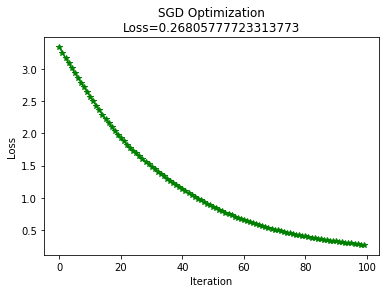

Training...
iter  0: y_pred = [-0.00022,  0.00051,  0.00034,  0.00070,  0.00028,  0.00122], loss: 3.332e+00
iter 50: y_pred = [ 0.62422, -0.83417,  0.63624,  0.81116, -0.69211, -0.53279], loss: 4.525e-02
Actual vs Predicted:
[ 0.64447554 -0.92569097  0.6678121   0.9735639  -0.68801814 -0.43752836]
[0.6452756994939641, -0.9033736746297787, 0.6690755544839511, 0.9535165763784924, -0.6837271453973008, -0.41737458799120275]


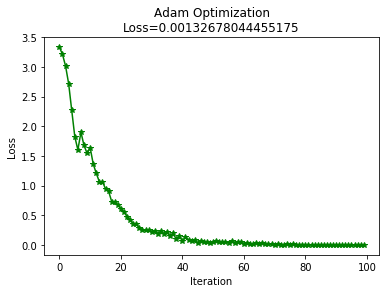

In [6]:
import numpy as np
import sys
import pandas as pd
import datetime
import sys
import random
import time
import math
from matplotlib import pyplot as plt

class Optimizer:
    #USE SAME DEFAULTS AS KERAS ADAM OPTIMIZER
    def __init__(self, lr=.1, beta_1=0.9, beta_2=0.999,
                 epsilon=0, decay=0., **kwargs):
        
        allowed_kwargs = {'clipnorm', 'clipvalue'}
        for k in kwargs:
            if k not in allowed_kwargs:
                raise TypeError('Unexpected keyword argument '
                                'passed to optimizer: ' + str(k))
        self.__dict__.update(kwargs)
        self.iterations = 1
        self.lr = lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.decay = decay
        self.epsilon = epsilon
        self.initial_decay = decay

    def get_ADAM(self, params, grads):

        original_shapes = [x.shape for x in params]
        params = [x.flatten() for x in params]
        grads = [x.flatten() for x in grads]
        
        lr = self.lr
        if self.initial_decay > 0:
            lr *= (1. / (1. + self.decay * self.iterations))

        t = self.iterations + 1
        lr_t = lr * (np.sqrt(1. - np.power(self.beta_2, t)) /
                     (1. - np.power(self.beta_1, t)))

        if not hasattr(self, 'ms'):
            self.ms = [np.zeros(p.shape) for p in params]
            self.vs = [np.zeros(p.shape) for p in params]
    
        ret = [None] * len(params)
        for i, p, g, m, v in zip(range(len(params)), params, grads, self.ms, self.vs):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * np.square(g)
            p_t = p - lr_t * m_t / (np.sqrt(v_t) + self.epsilon)
            self.ms[i] = m_t
            self.vs[i] = v_t
            ret[i] = p_t
        self.iterations += 1
  
        for i in range(len(ret)):
            ret[i] = ret[i].reshape(original_shapes[i])

        return np.array(ret)


    def get_SGD(self, w,p):
        for x,y in zip(w,p):
                    x+=self.lr*y
        return w[0],w[1],w[2],w[3],w[4],w[5],w[6],w[7],w[8],w[9]




def sigmoid(x): 
    return 1. / (1 + np.exp(-x))

def sigmoid_derivative(values): 
    return values*(1-values)

def tanh_derivative(values): 
    return 1. - values ** 2

# createst uniform random array w/ values in [a,b) and shape args
def rand_arr(a, b, *args): 
    np.random.seed(0)
    return (np.random.rand(*args) * (b - a) + a)*.1

class LstmParam:
    def __init__(self, mem_cell_ct, x_dim,optimization):
        self.mem_cell_ct = mem_cell_ct
        self.x_dim = x_dim
        concat_len = x_dim + mem_cell_ct
        
        self.opt=Optimizer()
        self.optimization=optimization

        # weight matrices
        self.wg = rand_arr(-0.1, 0.1, mem_cell_ct, concat_len)
        self.wi = rand_arr(-0.1, 0.1, mem_cell_ct, concat_len) 
        self.wf = rand_arr(-0.1, 0.1, mem_cell_ct, concat_len)
        self.wo = rand_arr(-0.1, 0.1, mem_cell_ct, concat_len)

        # bias terms
        self.bg = rand_arr(-0.1, 0.1, mem_cell_ct) 
        self.bi = rand_arr(-0.1, 0.1, mem_cell_ct) 
        self.bf = rand_arr(-0.1, 0.1, mem_cell_ct) 
        self.bo = rand_arr(-0.1, 0.1, mem_cell_ct)


        
        # diffs (derivative of loss function w.r.t. all parameters)
        self.wg_diff = np.zeros((mem_cell_ct, concat_len)) 
        self.wi_diff = np.zeros((mem_cell_ct, concat_len)) 
        self.wf_diff = np.zeros((mem_cell_ct, concat_len)) 
        self.wo_diff = np.zeros((mem_cell_ct, concat_len)) 
        self.bg_diff = np.zeros(mem_cell_ct) 
        self.bi_diff = np.zeros(mem_cell_ct) 
        self.bf_diff = np.zeros(mem_cell_ct) 
        self.bo_diff = np.zeros(mem_cell_ct) 

    def apply_diff(self, lr = .1):
        if(self.optimization=='adam'):
            self.wg=self.opt.get_ADAM(self.wg,self.wg_diff)
            self.wi=self.opt.get_ADAM(np.array(self.wi),np.array(self.wi_diff))
            self.wf=self.opt.get_ADAM(np.array(self.wf),np.array(self.wf_diff))
            self.wo=self.opt.get_ADAM(np.array(self.wo),np.array(self.wo_diff))

        else:
            #This is the stochastic gradient descent code
            self.wg -= lr * self.wg_diff
            self.wi -= lr * self.wi_diff
            self.wf -= lr * self.wf_diff
            self.wo -= lr * self.wo_diff


        
        self.bg -= lr * self.bg_diff
        self.bi -= lr * self.bi_diff
        self.bf -= lr * self.bf_diff
        self.bo -= lr * self.bo_diff
        
        # reset diffs to zero
        self.wg_diff = np.zeros_like(self.wg)
        self.wi_diff = np.zeros_like(self.wi) 
        self.wf_diff = np.zeros_like(self.wf) 
        self.wo_diff = np.zeros_like(self.wo) 
        self.bg_diff = np.zeros_like(self.bg)
        self.bi_diff = np.zeros_like(self.bi) 
        self.bf_diff = np.zeros_like(self.bf) 
        self.bo_diff = np.zeros_like(self.bo) 

class LstmState:
    def __init__(self, mem_cell_ct, x_dim):
        self.g = np.zeros(mem_cell_ct)
        self.i = np.zeros(mem_cell_ct)
        self.f = np.zeros(mem_cell_ct)
        self.o = np.zeros(mem_cell_ct)
        self.s = np.zeros(mem_cell_ct)
        self.h = np.zeros(mem_cell_ct)
        self.bottom_diff_h = np.zeros_like(self.h)
        self.bottom_diff_s = np.zeros_like(self.s)
    
class LstmNode:
    def __init__(self, lstm_param, lstm_state):
        # store reference to parameters and to activations
        self.state = lstm_state
        self.param = lstm_param

        # non-recurrent input concatenated with recurrent input
        self.xc = None

    def bottom_data_is(self, x, s_prev = None, h_prev = None):
        # if this is the first lstm node in the network
        if s_prev is None: s_prev = np.zeros_like(self.state.s)
        if h_prev is None: h_prev = np.zeros_like(self.state.h)
        # save data for use in backprop
        self.s_prev = s_prev
        self.h_prev = h_prev

        # concatenate x(t) and h(t-1)
        xc = np.hstack((x,  h_prev))
        self.state.g = np.tanh(np.dot(self.param.wg, xc) + self.param.bg)
        self.state.i = sigmoid(np.dot(self.param.wi, xc) + self.param.bi)
        self.state.f = sigmoid(np.dot(self.param.wf, xc) + self.param.bf)
        self.state.o = sigmoid(np.dot(self.param.wo, xc) + self.param.bo)
        self.state.s = self.state.g * self.state.i + s_prev * self.state.f
        self.state.h = self.state.s * self.state.o

        self.xc = xc

    
    def top_diff_is(self, top_diff_h, top_diff_s):
        # notice that top_diff_s is carried along the constant error carousel
        ds = self.state.o * top_diff_h + top_diff_s
        do = self.state.s * top_diff_h
        di = self.state.g * ds
        dg = self.state.i * ds
        df = self.s_prev * ds

        # diffs w.r.t. vector inside sigma / tanh function
        di_input = sigmoid_derivative(self.state.i) * di 
        df_input = sigmoid_derivative(self.state.f) * df 
        do_input = sigmoid_derivative(self.state.o) * do 
        dg_input = tanh_derivative(self.state.g) * dg

        # diffs w.r.t. inputs
        self.param.wi_diff += np.outer(di_input, self.xc)
        self.param.wf_diff += np.outer(df_input, self.xc)
        self.param.wo_diff += np.outer(do_input, self.xc)
        self.param.wg_diff += np.outer(dg_input, self.xc)
        self.param.bi_diff += di_input
        self.param.bf_diff += df_input       
        self.param.bo_diff += do_input
        self.param.bg_diff += dg_input

        #for dparam in [self.param.wi_diff, self.param.wf_diff , self.param.wo_diff, self.param.wg_diff, self.param.bi_diff, self.param.bf_diff, self.param.bo_diff, self.param.bg_diff]:
        #    np.clip(dparam, -1, 1, out=dparam)

        # compute bottom diff
        dxc = np.zeros_like(self.xc)
        dxc += np.dot(self.param.wi.T, di_input)
        dxc += np.dot(self.param.wf.T, df_input)
        dxc += np.dot(self.param.wo.T, do_input)
        dxc += np.dot(self.param.wg.T, dg_input)

        # save bottom diffs
        self.state.bottom_diff_s = ds * self.state.f
        self.state.bottom_diff_h = dxc[self.param.x_dim:]

class LstmNetwork():
    def __init__(self, lstm_param, loss):
        self.lstm_param = lstm_param
        self.lstm_node_list = []
        # input sequence
        self.x_list = []
        self.loss=loss

    def y_list_is(self, y_list, loss_layer):
        """
        Updates diffs by setting target sequence 
        with corresponding loss layer. 
        Will *NOT* update parameters.  To update parameters,
        call self.lstm_param.apply_diff()
        """
        assert len(y_list) == len(self.x_list)
        idx = len(self.x_list) - 1
        # first node only gets diffs from label ...
        loss = loss_layer.loss(self.lstm_node_list[idx].state.h, y_list[idx],self.loss)

        diff_h =loss_layer.bottom_diff(self.lstm_node_list[idx].state.h, y_list[idx])

        # here s is not affecting loss due to h(t+1), hence we set equal to zero
        diff_s = np.zeros(self.lstm_param.mem_cell_ct)
        self.lstm_node_list[idx].top_diff_is(diff_h, diff_s)
        idx -= 1

        ### ... following nodes also get diffs from next nodes, hence we add diffs to diff_h
        ### we also propagate error along constant error carousel using diff_s
        while idx >= 0:
            loss += loss_layer.loss(self.lstm_node_list[idx].state.h, y_list[idx],self.loss)
            diff_h = loss_layer.bottom_diff(self.lstm_node_list[idx].state.h, y_list[idx])
            diff_h += self.lstm_node_list[idx + 1].state.bottom_diff_h
            diff_s = self.lstm_node_list[idx + 1].state.bottom_diff_s
            self.lstm_node_list[idx].top_diff_is(diff_h, diff_s)
            idx -= 1 

        return loss

    def x_list_clear(self):
        self.x_list = []

    def x_list_add(self, x):
        self.x_list.append(x)
       # print(self.x_list)
        if len(self.x_list) > len(self.lstm_node_list):
            # need to add new lstm node, create new state mem
            lstm_state = LstmState(self.lstm_param.mem_cell_ct, self.lstm_param.x_dim)
            self.lstm_node_list.append(LstmNode(self.lstm_param, lstm_state))

        # get index of most recent x input
        idx = len(self.x_list) - 1
        if idx == 0:
            # no recurrent inputs yet
            self.lstm_node_list[idx].bottom_data_is(x)
        else:
            s_prev = self.lstm_node_list[idx - 1].state.s
            h_prev = self.lstm_node_list[idx - 1].state.h
            self.lstm_node_list[idx].bottom_data_is(x, s_prev, h_prev)



class LossLayer:
    """
    Computes square loss with first element of hidden layer array.
    MG-Attempted to add in mae loss for comparison, but RMSE and MAE loss performed the same.  
    """
    @classmethod
    def loss(self,pred, label,fn):
        if(fn=='mae'):
            return LossLayer.loss_mae(pred,label)
        else:
            return LossLayer.loss_rmse(pred,label)
    
    # MG added mean absolute error
    @classmethod
    def loss_mae(self, pred, label):
        return (np.abs(pred[0]-label))
        #return (pred[0] - label) ** 2
    
    @classmethod
    def loss_rmse(self, pred, label):
        return (pred[0] - label) ** 2

    @classmethod
    def bottom_diff(self, pred, label):
        diff = np.zeros_like(pred)
        diff[0] =2*(pred[0] - label)
        return diff



def train(loss, optimization):
    mem_cell_ct = 50
    x_dim = 4
    lstm_param = LstmParam(mem_cell_ct, x_dim,optimization)
    lstm_net = LstmNetwork(lstm_param,loss)
    losses=[]
    bestLoss=1e5
    print("Training...")
    for cur_iter in range(100):
       
        for ind in range(len(Y)):
            lstm_net.x_list_add(X[ind])

        if(cur_iter%50==0):
            print("iter", "%2s" % str(cur_iter), end=": ")
            print("y_pred = [" +
                  ", ".join(["% 2.5f" % lstm_net.lstm_node_list[ind].state.h[0] for ind in range(len(Y))]) +
                  "]", end=", ")

        loss = lstm_net.y_list_is(Y, LossLayer)
        losses.append(loss)
        if(loss<bestLoss):
            best_lstm_net = LstmNetwork(lstm_param,loss)
            
        lstm_param.apply_diff(lr=0.1)
        
        if(cur_iter%50==0):
            print("loss:", "%.3e" % loss)

        lstm_net.x_list_clear()
    
    for ind in range(len(Y)):
        best_lstm_net.x_list_add(X[ind])   
    loss = best_lstm_net.y_list_is(Y, LossLayer)
    return losses, [ best_lstm_net.lstm_node_list[ind].state.h[0] for ind in range(len(Y))],loss



def firstTurbineData():
	df = pd.read_csv('la-haute-borne-data-2013-2016.csv', sep=';')
	df['Date_time'] = df['Date_time'].astype(str).str[:-6] #remove timezone (caused me an hour of pain)
	df.Date_time=pd.to_datetime(df['Date_time'])
	df=df.fillna(method='ffill')

	df=df.sort_values(by='Date_time')
	df = df.reset_index()
	turbines=df.Wind_turbine_name.unique()
	print("Turbine name: "+str(turbines[0]))
	turbineData=df[df['Wind_turbine_name']==turbines[0]]
	return turbineData


def createGraph(losses, title):
	X = np.arange(0,len(losses))
	figure = plt.figure()
	tick_plot = figure.add_subplot(1, 1, 1)
	tick_plot.plot(X, losses,  color='green', linestyle='-', marker='*' )
	plt.xlabel('Iteration')
	plt.ylabel('Loss')
	plt.title(title)
	plt.show()


np.random.seed(0)
date_to_test=datetime.datetime(2016, 1, 1)
turbineData=np.sin(firstTurbineData().Wa_c_avg.values)[:10]
X=np.array([turbineData[:4],
                   turbineData[1:5],
                   turbineData[2:6],
                   turbineData[3:7],
                   turbineData[4:8],
                   turbineData[5:9]])
Y=np.array([turbineData[4],
                   turbineData[5],
                   turbineData[6],
                   turbineData[7],
                   turbineData[8],
                   turbineData[9]])


losses, predictions,loss=train('rmse','sgd')
print("Actual vs Predicted:")
print(Y)
print(predictions)
createGraph(losses,"SGD Optimization\nLoss="+str(loss))
losses, predictions,loss=train('rmse','adam')
print("Actual vs Predicted:")
print(Y)
print(predictions)
createGraph(losses,"Adam Optimization\nLoss="+str(loss))

<a id='numpylstm_walkthrough'></a>
## Code walkthrough

Breakdown of an LSTM layer (from http://blog.varunajayasiri.com/numpy_lstm.html):
![title](http://blog.varunajayasiri.com/ml/lstm.svg)

### Train Method Explanation: 

LstmParam:
Initialize LstmParam object with hidden cell count (mem_cell_ct) and x_dim.  This object holds the networks weights, bias terms, and weight differences (derivative of loss function).  

LstmNetwork:
Holds Xlist for forward propagation. 

We will train the network for 100 iterations.  

#### Forward propagation
For each input value x[idx], I call the x_list_add method of the LstmNetwork:
x_list_add:<br>
If x_list > lstm_node_list:<br>
- Create new LstmState.  The layers of the network should all be initialized to 0 arrays. 
- add LstmNode to lstm_node_list with LstmState with 0 arrays. 

If index of X input is 0:
- Call lstm_node_list[idx].bottom_data_is(x) and forward propagate through the different inner modules of the LSTM Network.  LstmNode has "states" for each module, e.g. self.state.g, self.state.i.  state.s=C in the image above.  self.h and self.s get passed to the next input by being set via s_prev and h_prev, respectively. 
If index of X input is Not 0:
- Call lstm_node_list[idx].bottom_data_is(x) and forward propagate through the different inner modules of the LSTM Network with the previous inputs s_prev and h_prev values.  

Forward propagation yields the networks output guesses in its h[0] values, so we will print those periodically.  

#### Calculating loss (y_list_is method):
- input correct Y values.  To start, we take the last index from the lstm_node_list and calculate its loss by sending its h value to the loss function and returning the squared error of h[0] from its actual value, Y[idx].  

- Calculate diff_h.  Find the error of the h[0] compared to the Y value.  I was unsure why Nick multiplied this error by 2, but it seemed to learn (at different rates) no matter what multiplication value you gave it.  Perhaps the 2 was to speed up learning by accentuating the loss? I'm not quite sure.  

- For the last value, s (c) will be zero because it doesn't affect loss.

- Backpropagate on final input value.  top_diff_is is self explanatory, computing the derivatives of each module in the LSTM layer.  

- From here we backwards through the input data and perform the same back propagation: get the loss of the value compared to Y, get the loss of diff_h and diff_s, and backpropagate through the different modules.  diff_h is computed by finding the loss of the output value at the current index and then adding the loss of the value at the index+1.  diff_s is computed by getting the value of the diff_s at index+1.  

#### Apply weights (apply_diff method):
- Here is where I implemented Adam optimization.  We update weights and biases here by adding the diffs to the weights.  For example, self.wi weights are updated by adding the self.wi_diff*learning rate for SGD optimization. Adam optimization is different but follows a similar idea.  After the weights and biases are updated, we set the _diff variables back to zero.  

From here we clear the x values and start another iteration. 



<a id='rl'></a>


# Part 3

# Reinforcement Learning for the Multi Armed Bandit Problem

# Solving the Multi-Armed Bandit Problem with Simple Reinforcement Learning


The purpose of this exercise was to get my feet wet with simple reinforcement learning algorithms.  My goal was to write as simple code as possible for both learning purposes and readability.  <br>

I solved the [multi-armed bandit problem](https://en.wikipedia.org/wiki/Multi-armed_bandit), a common machine learning problem.  I used a Bernoulli Bandit, which issues as reward of 1 with a probability of p and otherwise a reward of 0. 

Policies included:
-  Random 
-  Greedy 
-  Epsilon 
-  Epsilon Decay 
-  Thompson Sampling
-  Upper Confidence Bound (UCB)

The "Machine Learning" part of this can be considered the dictionary Q, where I hold the reward values of each arm.  For example in epsilon greedy, if we pull an arm and win the reward, we increment the Q value of the that arm by:<br>
Q[selection]+=((1/action_attempts[selection])*(1-Q[selection]))



### Random
The random approach is self explanatory.  We select a random arm from the bandit.  If we win with the random selection, I increment the score by 1.  

### Greedy
In the greedy approach, I choose the arm that has the highest reward.  Since all arms have zero rewards to begin with, it takes a random arm.  If this arm has the highest reward of all arms, then the greedy algorithm will do well.  However, most times it will lock onto an arm that is suboptimal and keep selecting this one.  It's reward will slowly increase, causing the algorithm to continue selecting this option.  This is not a great algorithm.  

### Epsilon
The epsilon algorithm selects a random value epsilon% of the time, and selects the value with the best reward (Q value) (1-epsilon) % of the time.  

### Epsilon Decay
Epsilon Decay lowers the epsilon value each iteration by a decay rate and follows the above logic.  This means that the further we get in the game, the more we should know about the rewards of each arm.  Therefore as epsilon decreases we will select the arm with the highest reward more and more.

### Thompson Sampling
Thompson Sampling uses the beta distribution.  We initalize alpha and beta to 1 because we are uncertain of each. If we are rewarded, we increment alpha by 1.  We add (1-reward) to beta.  [A smart guy on Quora](https://www.quora.com/What-is-Thompson-sampling-in-laymans-terms) explains Thompson Sampling well, and once I understood the beta distribution part of it, it was fairly easy to code.  

### UCB
I found a good explanation of the UCB algorithm in this link-https://stats.stackexchange.com/questions/323867/upper-confidence-bound-in-machine-learning<br>
N is the total number sampled and n is the total of a particular bandit sampled.  C is a constant. I am unsure if the equation was implemented perfectly, but the results seem to be consistently strong.  
![title](ucb.png)

5 armed bandit probabilities
[0.13857907 0.71596157 0.4309315  0.02253543 0.66405794]

Random Action
{1: 0.1588785046728973, 2: 0.7499999999999998, 3: 0.5051546391752576, 4: 0.019801980198019806, 5: 0.6504854368932038}
Score: 204

Greedy
{1: 0.162, 2: 0, 3: 0, 4: 0, 5: 0}
Score: 81

Epsilon Greedy No Decay
{1: 0.1612903225806452, 2: 0.7428571428571432, 3: 0.5789473684210527, 4: 0.0, 5: 0.6933333333333334}
Score: 328

Epsilon Greedy with Decay
{1: 0.0, 2: 0.0, 3: 0.41666666666666696, 4: 0.0, 5: 0.0}
Score: 205

Thompson Sampling
Score: 328

UCB
[0.18181818181818185, 0.6923076923076923, 0.47058823529411764, 0.0, 0.7573770491803279]
Score: 348


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:151: RuntimeWarning: invalid value encountered in sqrt


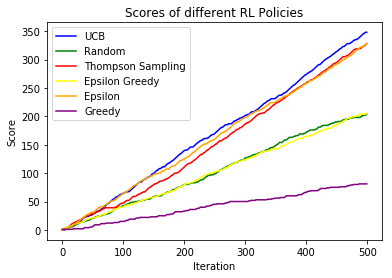

In [2]:
import numpy as np
import math
import operator
import random
from matplotlib import pyplot as plt

random.seed()

#10 armed bandit
num_bandits=5
mab=np.random.rand(num_bandits)
print(str(num_bandits)+" armed bandit probabilities")
print(mab)

#number of pulls in game
maxsteps=500


def greedy():
    best=max(Q.items(), key=operator.itemgetter(1))
    return best[0]

def random_selection():
    return random.randint(1, num_bandits)

def epsilonGreedy():
    if np.random.uniform() < epsilon:
        # Random Move
        return random_selection()
    else:
        # Greedy Move
        return greedy()

#random 
print("\nRandom Action")
Q={i:0 for i in range(1,num_bandits+1)}
action_attempts={i:0 for i in range(1,num_bandits+1)}
score=0
rando=[]
for step in range(maxsteps):
    selection=random_selection()
    action_attempts[selection]+=1    
    reward=0
    if(random.uniform(0, 1)<mab[selection-1]):
        reward=1
        score+=1
    Q[selection]+=((1/action_attempts[selection])*(reward-Q[selection]))
    rando.append(score)
print(Q)
print("Score: "+str(score))



#greedy
print("\nGreedy")
Q={i:0 for i in range(1,num_bandits+1)}
action_attempts={i:0 for i in range(1,num_bandits+1)}
score=0
gre=[]
for step in range(maxsteps):

    selection=greedy()
    action_attempts[selection]+=1
    reward=0
    if(random.uniform(0, 1)<mab[selection-1]):
        score+=1
        reward=1

    Q[selection]+=((1/action_attempts[selection])*(reward-Q[selection]))
    gre.append(score)
print(Q)
print("Score: "+str(score))



#epsilon greedy no decay
print("\nEpsilon Greedy No Decay")
epsilon=.2
Q={i:0 for i in range(1,num_bandits+1)}
action_attempts={i:0 for i in range(1,num_bandits+1)}
score=0
learningRate=0.2
ep=[]
for step in range(maxsteps):
    selection=epsilonGreedy()
    action_attempts[selection]+=1
    #print(selection)
    reward=0
    if(random.uniform(0, 1)<mab[selection-1]):
        reward=1
        score+=1
    Q[selection]+=((1/action_attempts[selection])*(reward-Q[selection]))
    ep.append(score)
print(Q)
print("Score: "+str(score))




#epsilon greedy with decay
epsilon=1
decayRate=.9
print("\nEpsilon Greedy with Decay")
Q={i:0 for i in range(1,num_bandits+1)}
action_attempts={i:0 for i in range(1,num_bandits+1)}
score=0
ep_dec=[]
for step in range(maxsteps):
    epsilon*=decayRate
    selection=epsilonGreedy()
    action_attempts[selection]+=1
    reward=0
    if(random.uniform(0, 1)<mab[selection-1]):
        reward=1
        score+=1
    Q[selection]+=((1/action_attempts[selection])*(reward-Q[selection]))
    ep_dec.append(score)
print(Q)
print("Score: "+str(score))


#Thompson sampling
alpha=[1]*num_bandits
beta=[1]*num_bandits
print("\nThompson Sampling")
score=0
ts=[]
for step in range(maxsteps):
    sample=[np.random.beta(alpha[x],beta[x]) for x in range(num_bandits)]
    selection=sample.index(max(sample))
    reward=0
    if(random.uniform(0, 1)<mab[selection-1]):
        reward=1
        score+=1
    alpha[selection]+=reward
    beta[selection]+=(1-reward)
    ts.append(score)
print("Score: "+str(score))




#UCB
print("\nUCB")
ucb=[]
probs=[1]*num_bandits
action_attempts={i:0 for i in range(1,num_bandits+1)}
score=0
np.seterr(divide = 'ignore') 
for step in range(maxsteps):
    sample=[probs[x]+np.sqrt(np.log(step)/(1+action_attempts[x+1])) for x in range(num_bandits)]
    selection=sample.index(max(sample))
    action_attempts[selection+1]+=1
    reward=0
    if(random.uniform(0, 1)<mab[selection]):
        reward=1
        score+=1
    probs[selection]+=((1/action_attempts[selection+1])*(reward-probs[selection]))
    ucb.append(score)
print(probs)
print("Score: "+str(score))




X = np.arange(maxsteps)
figure = plt.figure()
tick_plot = figure.add_subplot(1, 1, 1)
tick_plot.plot(X, ucb,  color='blue', linestyle='-',label='UCB')
tick_plot.plot(X, rando,  color='green', linestyle='-',label='Random')
tick_plot.plot(X, ts,  color='red', linestyle='-',label='Thompson Sampling')
tick_plot.plot(X, ep_dec,  color='yellow', linestyle='-',label='Epsilon Greedy')
tick_plot.plot(X, ep,  color='orange', linestyle='-',label='Epsilon')
tick_plot.plot(X, gre,  color='purple', linestyle='-',label='Greedy')
plt.title("Scores of different RL Policies")
plt.legend(loc='upper left')
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.show()


<a id='references'></a>
# References
-  http://colah.github.io/posts/2015-08-Understanding-LSTMs/ (Chris Olah)
-  https://github.com/nicodjimenez/lstm/blob/master/lstm.py (Nick Jimenez)
-  https://opendata-renewables.engie.com/explore/dataset/la-haute-borne-data-2013-2016/table/ (Wind Direction Dataset, Engie)
-  https://mattgorb.github.io/wind_multivariatelstm,https://mattgorb.github.io/wind (Matt Gorbett)
-  https://www.quora.com/What-is-Stationary-series-and-non-Stationary-series
-  https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424
-  https://github.com/keras-team/keras/issues/9385
-  https://medium.com/cindicator/backtesting-time-series-models-weekend-of-a-data-scientist-92079cc2c540
-  https://stats.stackexchange.com/questions/323867/upper-confidence-bound-in-machine-learning
-  https://www.quora.com/What-is-Thompson-sampling-in-laymans-terms

<a id='wordcount'></a>
# Project Word Count

In [6]:
import io
from IPython.nbformat import current
import glob
nbfile = glob.glob('Final-Matt Gorbett.ipynb')
if len(nbfile) > 1:
    print('More than one ipynb file. Using the first one.  nbfile=', nbfile)
with io.open(nbfile[0], 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')
word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print('Word count for file', nbfile[0], 'is', word_count)

Word count for file Final-Matt Gorbett.ipynb is 3143
